# Snow Cover Extent bias with 3D topography
conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 600 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [60]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'snc'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Snow Cover Extent'

## Get topography: GMTED2010, HR, LR

In [61]:
cmap_elevation='spectral_r'; levels_elevation=plot.arange(0,8000,100); cb_label_elevation='Elevation [m]'

In [6]:
topo_GMTED = xr.open_dataset('/data/mlalande/Relief/Relief_GMTED2010_15n015_00625deg.nc').RELIEF \
            .rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext).load()
# topo_GMTED

In [7]:
topo_IPSL_CM6A_LR = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).sel(lat=latlim_ext, lon=lonlim_ext).load()
# topo_IPSL_CM6A_LR

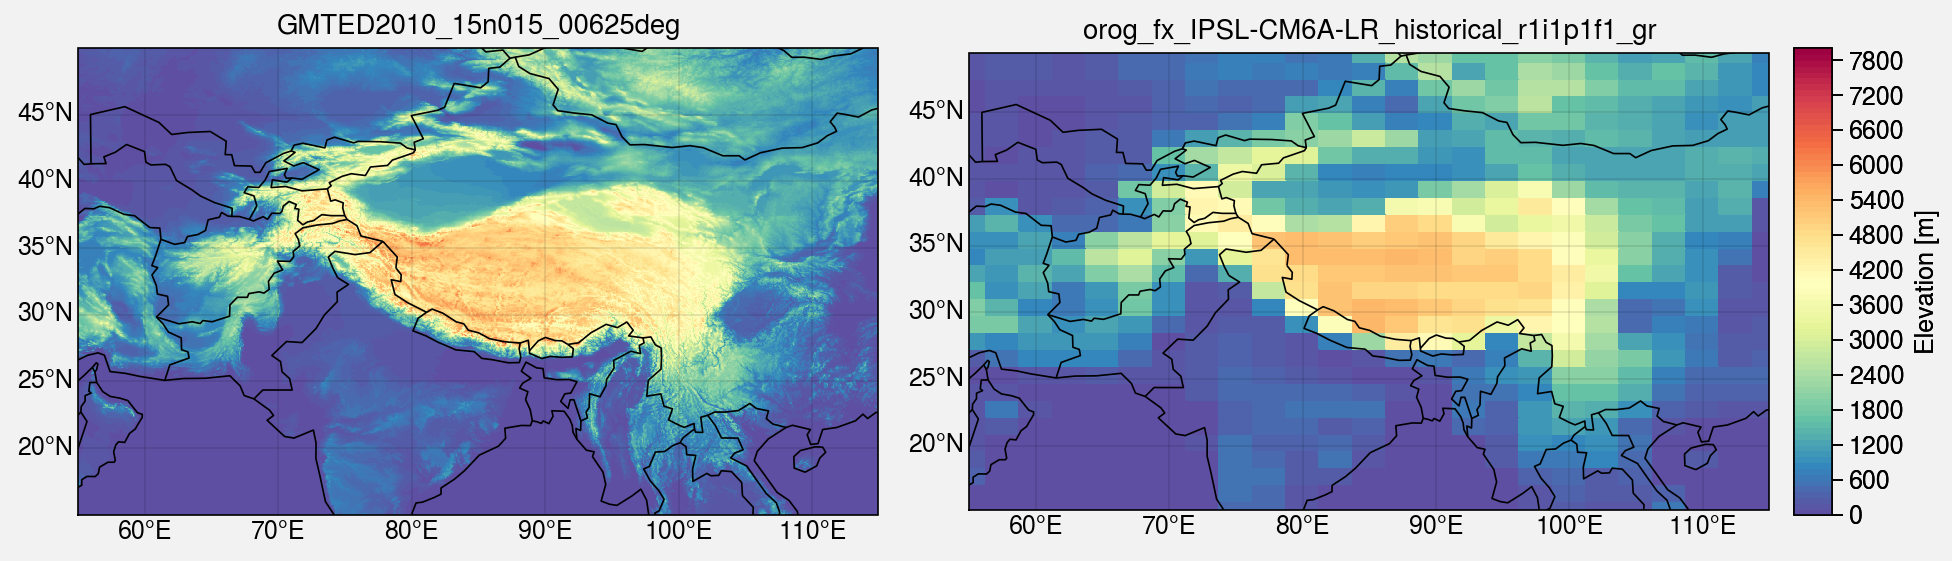

In [62]:
fig, axs = plot.subplots(nrows=1, ncols=2, proj='cyl', axwidth=4)

topo = [topo_GMTED, topo_IPSL_CM6A_LR]
topo_labels = ['GMTED2010_15n015_00625deg', 'orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr']

for i, ax in enumerate(axs):
    m = ax.pcolormesh(topo[i], cmap=cmap_elevation, levels=levels_elevation)
    ax.format(
        lonlim=(topo[i].lon.min(), topo[i].lon.max()), latlim=(topo[i].lat.min(), topo[i].lat.max()),
        labels=True, borders=True, coast=True, title=topo_labels[i]
    )
    
fig.colorbar(m, label=cb_label_elevation)

## Load Snow Cover Extent for: obs, HR, LR

In [64]:
da_LR = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).snc.sel(lat=latlim_ext, lon=lonlim_ext).sel(time=period).mean('time').load()

da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).snc.sel(lat=latlim_ext, lon=lonlim_ext).sel(time=period).mean('time').load()

ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period).rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100).mean('time').load()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


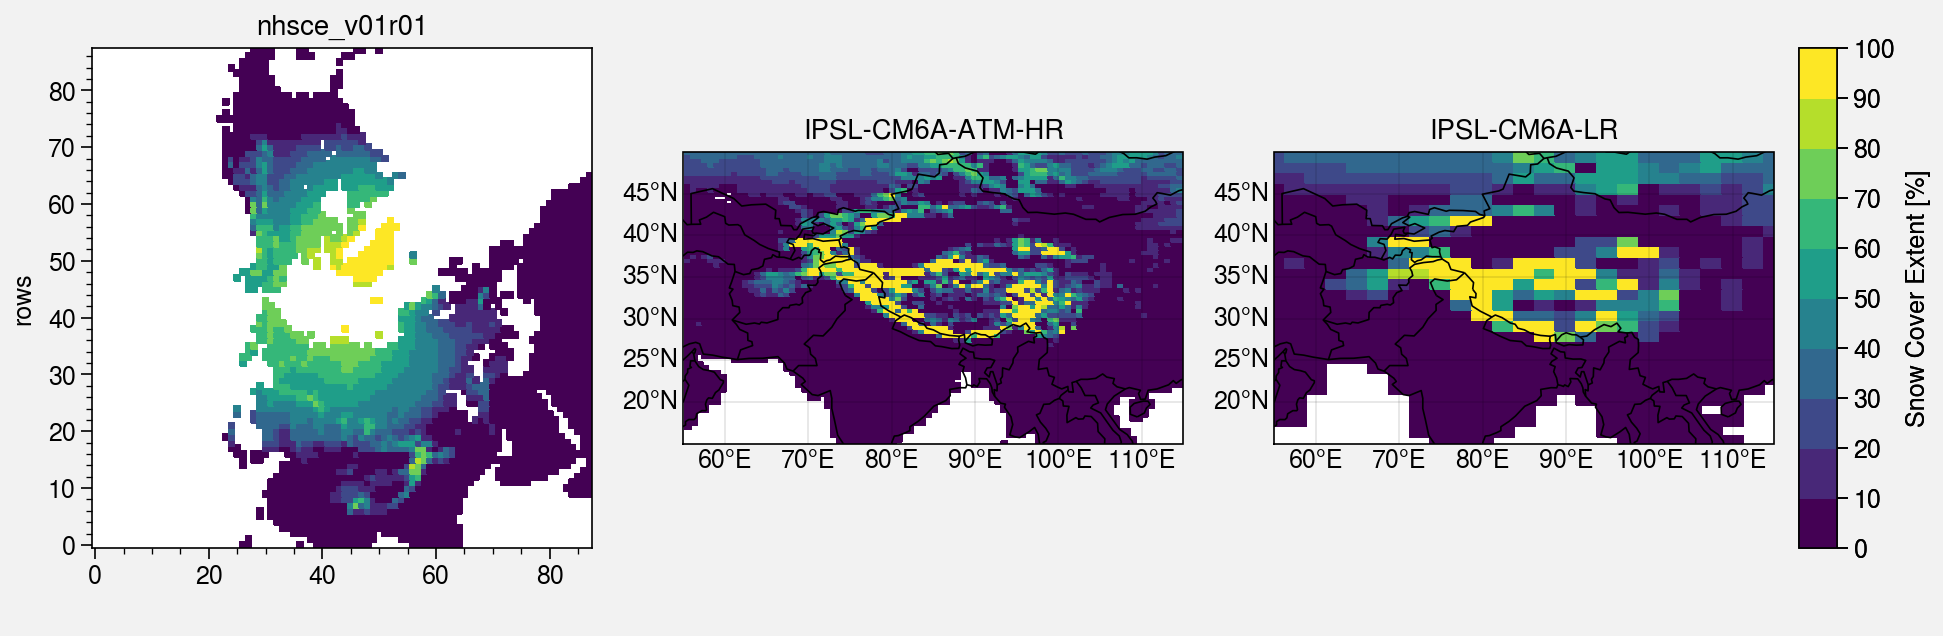

In [65]:
fig, axs = plot.subplots(nrows=1, ncols=3, proj=(None, 'cyl', 'cyl'))

da = [obs, da_HR, da_LR]
da_labels = ['nhsce_v01r01', 'IPSL-CM6A-ATM-HR', 'IPSL-CM6A-LR']

for i, ax in enumerate(axs):
    m = ax.pcolormesh(da[i], cmap=cmap, levels=levels)
    if i in [1,2]:
        ax.format(
            lonlim=(lonlim_ext.start, lonlim_ext.stop), latlim=(latlim_ext.start, latlim_ext.stop),
            labels=True, borders=True, coast=True, title=da_labels[i]
        )
        
axs[0].format(title=da_labels[0])
    
fig.colorbar(m, label=label+' ['+units+']')

## Make different regrids:
- obs -> HR, LR, GMTED
- obs, HR, LR -> GMTED

In [66]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

In [ ]:
regridder = xe.Regridder(obs, da_HR, 'bilinear', periodic=False)
regridder = add_matrix_NaNs(regridder)
print(regridder)

# Regrid the data
snc_rutger_regrid = regridder(snc_rutger)

## Make 3D plots

In [81]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter

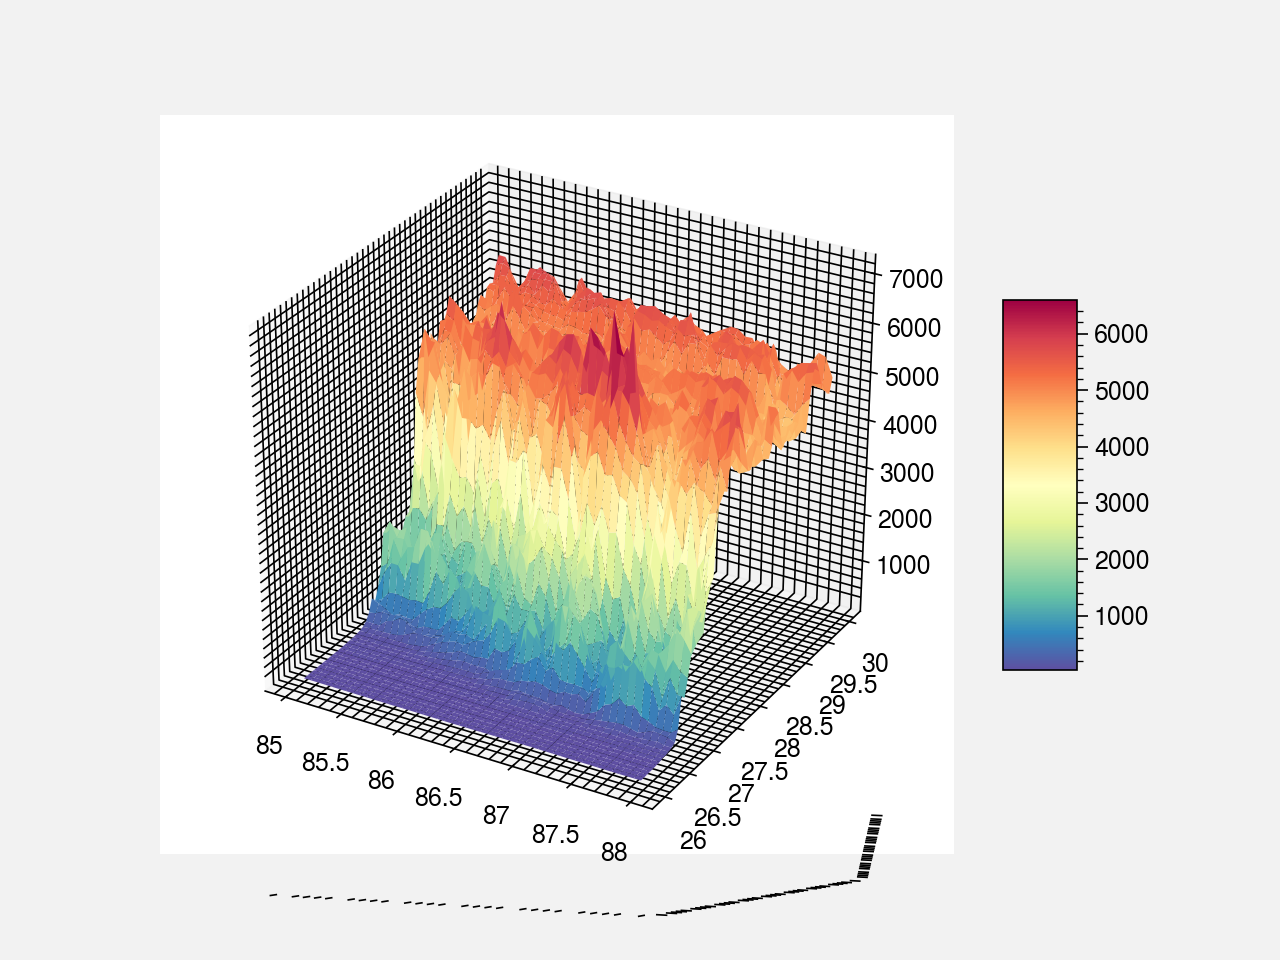

In [109]:
topo_GMTED_zoom = topo_GMTED.sel(lat=slice(26,30), lon=slice(85,88))
# topo_GMTED_zoom = topo_GMTED
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(20,40), lon=slice(70,100))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = topo_GMTED_zoom.lon.values
Y = topo_GMTED_zoom.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED_zoom.values

# ax.view_init(15, 310)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cmap_elevation, 
                       rstride=1, cstride=1
                      )



# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

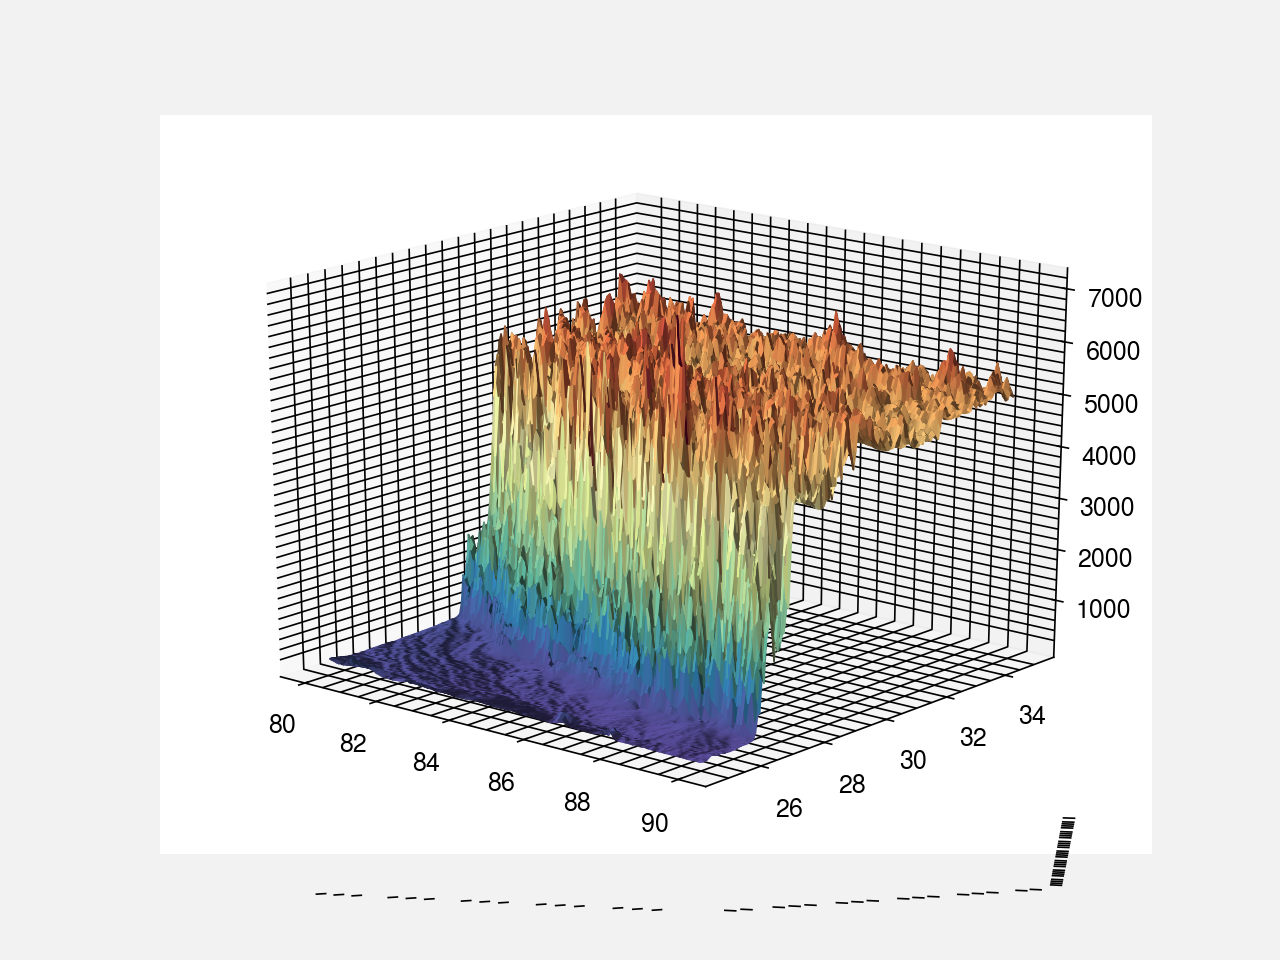

In [124]:
topo_GMTED_zoom = topo_GMTED.sel(lat=slice(25,35), lon=slice(80,90))
# topo_GMTED_zoom = topo_GMTED
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(20,40), lon=slice(70,100))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = topo_GMTED_zoom.lon.values
Y = topo_GMTED_zoom.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED_zoom.values

ax.view_init(20, 310)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, 
#                        cmap=cmap_elevation, 
                       rstride=1, cstride=1,
                       facecolors=cm.Spectral_r(Z/Z.max())
                      )



# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [123]:
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(26,40), lon=slice(70,100))
topo_GMTED_zoom = topo_GMTED(lat=slice(25,35), lon=slice(80,90))
# topo_GMTED_zoom = topo_GMTED
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(20,40), lon=slice(70,100))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = topo_GMTED_zoom.lon.values
Y = topo_GMTED_zoom.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED_zoom.values

# ax.view_init(15, 310)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, 
#                        cmap=cmap_elevation, 
                       rstride=1, cstride=1,
                       facecolors=cm.Spectral_r(Z/Z.max())
                      )

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

TypeError: 'DataArray' object is not callable

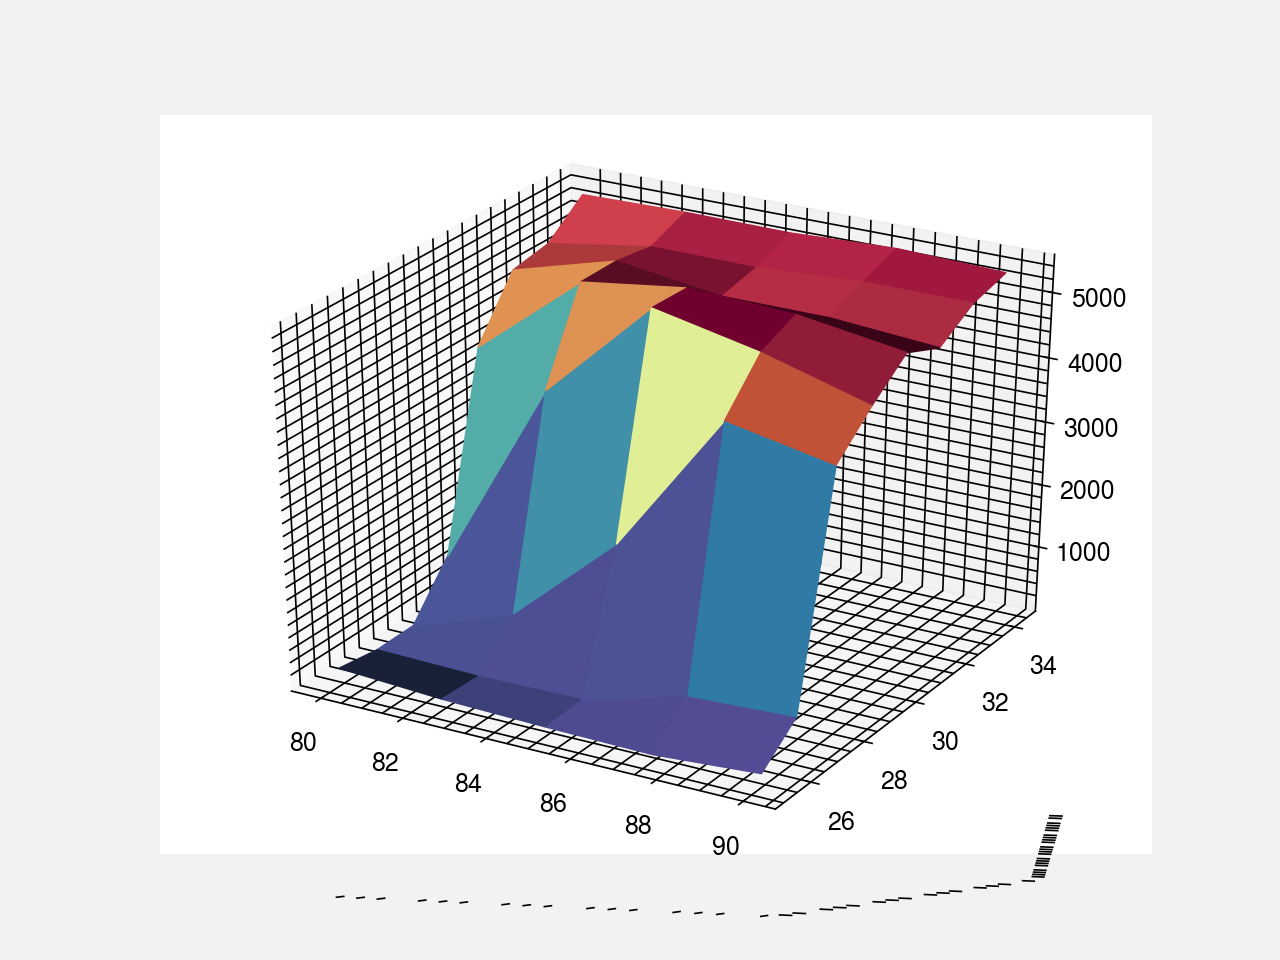

In [122]:
# topo_GMTED_zoom = topo_IPSL_CM6A_LR.sel(lat=slice(26,40), lon=slice(70,100))
topo_GMTED_zoom = topo_IPSL_CM6A_LR.sel(lat=slice(25,35), lon=slice(80,90))
# topo_GMTED_zoom = topo_GMTED
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(20,40), lon=slice(70,100))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = topo_GMTED_zoom.lon.values
Y = topo_GMTED_zoom.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED_zoom.values

# ax.view_init(15, 310)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, 
#                        cmap=cmap_elevation, 
                       rstride=1, cstride=1,
                       facecolors=cm.Spectral_r(Z/Z.max())
                      )

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

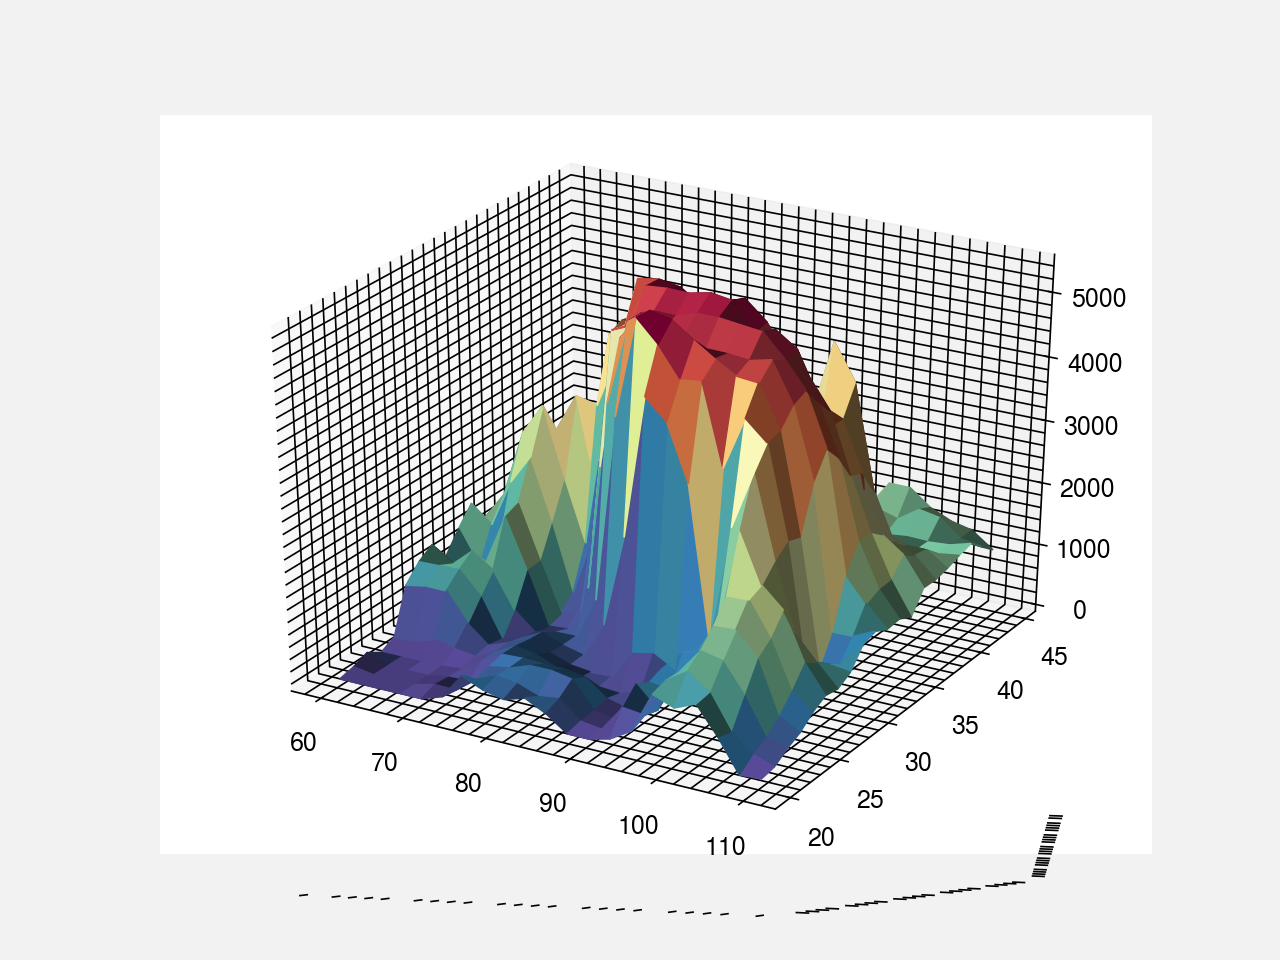

In [120]:
# topo_GMTED_zoom = topo_IPSL_CM6A_LR.sel(lat=slice(26,40), lon=slice(70,100))
topo_GMTED_zoom = topo_IPSL_CM6A_LR.sel(lat=slice(26,30), lon=slice(85,88))
# topo_GMTED_zoom = topo_GMTED
# topo_GMTED_zoom = topo_GMTED.sel(lat=slice(20,40), lon=slice(70,100))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = topo_GMTED_zoom.lon.values
Y = topo_GMTED_zoom.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED_zoom.values

# ax.view_init(15, 310)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, 
#                        cmap=cmap_elevation, 
                       rstride=1, cstride=1,
                       facecolors=cm.Spectral_r(Z/Z.max())
                      )

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


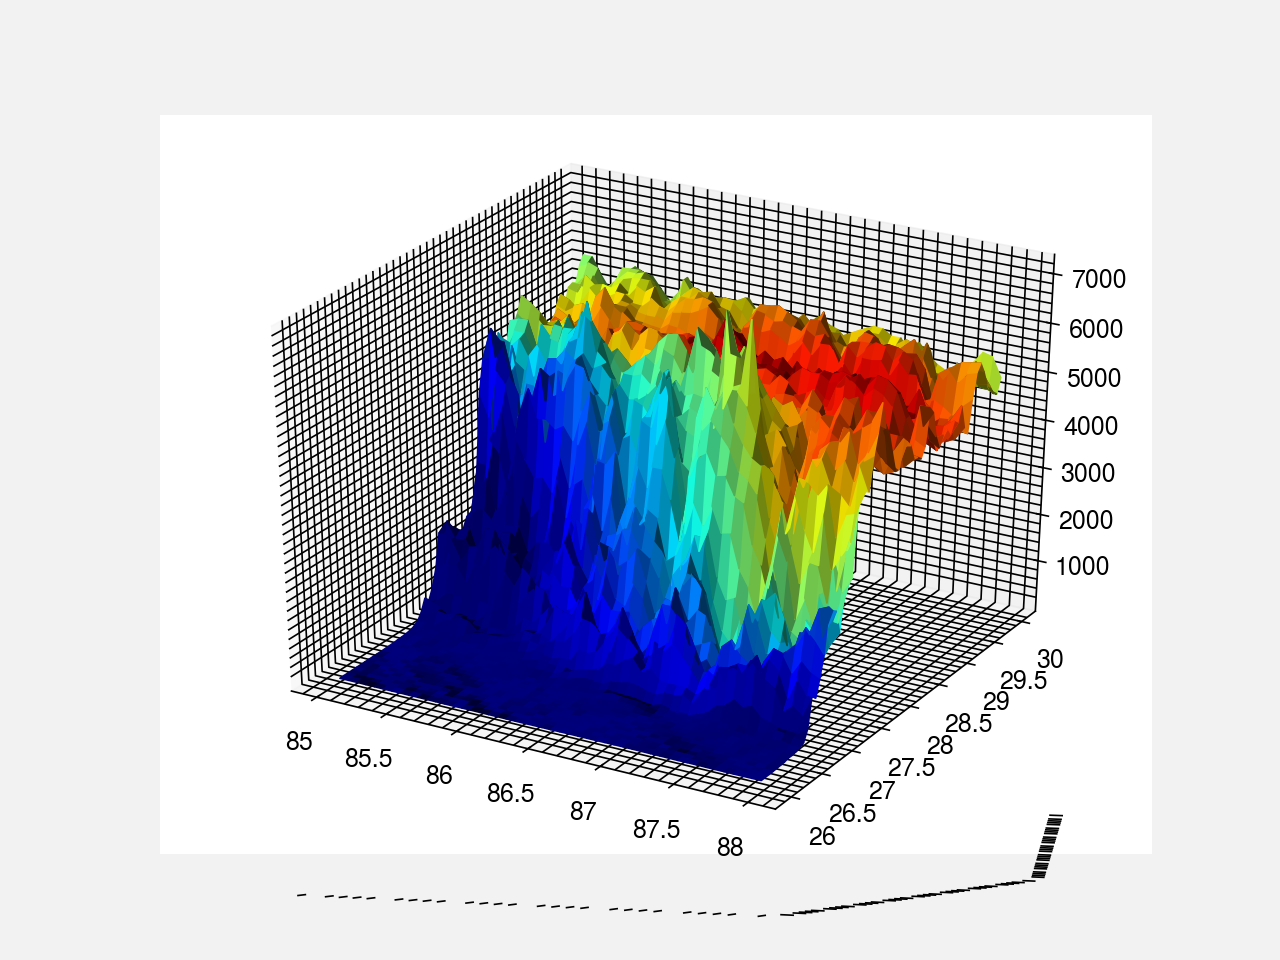

In [82]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(topo_GMTED_zoom.lon.values, topo_GMTED_zoom.lat.values)

# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(T/float(T.max())))
ax.plot_surface(X, Y, topo_GMTED_zoom.values, rstride=1, cstride=1, 
                facecolors=cm.jet(bias.sel(lat=slice(26,30), lon=slice(85,88))/float(bias.sel(lat=slice(26,30), lon=slice(85,88)).min()))
               )
plt.show()

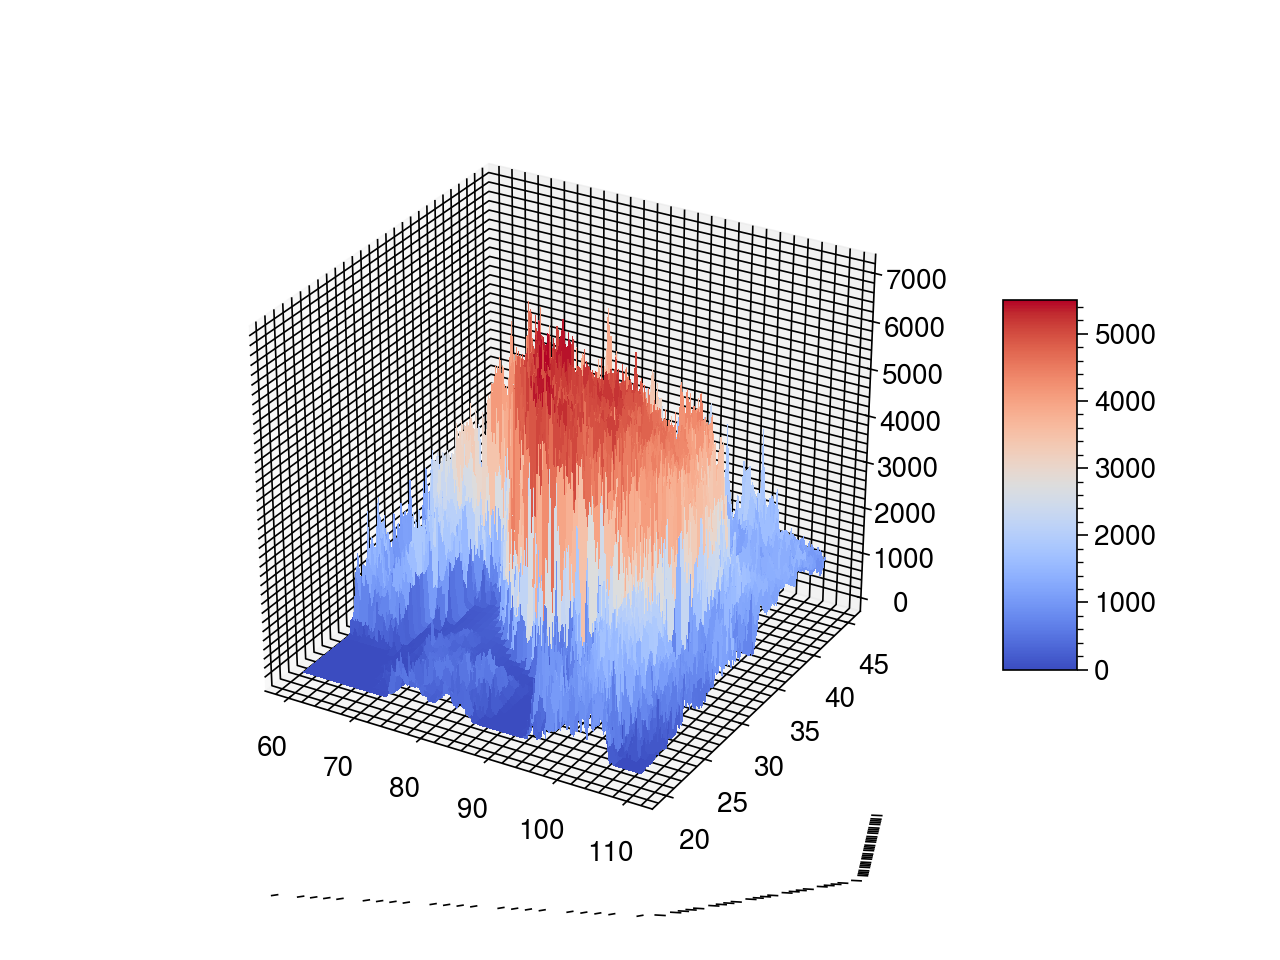

In [24]:
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = topo_GMTED.lon.values
Y = topo_GMTED.lat.values
X, Y = np.meshgrid(X, Y)
Z = topo_GMTED.values

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Compute snow bias

In [44]:
snc_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

snc_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

In [45]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)

In [46]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
snc_rutger.attrs['units'] = '%'

# Rename lon and lat for the regrid
snc_rutger = snc_rutger.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snc_rutger = snc_rutger.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
snc_rutger

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 432, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1979-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

In [53]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder = xe.Regridder(snc_rutger, topo_GMTED, 'bilinear', periodic=False)
regridder = add_matrix_NaNs(regridder)
print(regridder)

# Regrid the data
snc_rutger_regrid = regridder(snc_rutger)

Create weight file: bilinear_88x88_400x800.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_400x800.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (400, 800) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


In [50]:
snc_historical.mean('time')

<xarray.DataArray 'snc' (lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(143, 144), dtype=float32, chunksize=(143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [58]:
regridder = xe.Regridder(snc_historical, topo_GMTED, 'bilinear', periodic=False)
snc_historical_regrid = regridder(snc_historical.mean('time'))

Overwrite existing file: bilinear_143x144_400x800.nc 
 You can set reuse_weights=True to save computing time.


In [72]:
snc_historical_regrid

<xarray.DataArray 'snc' (lat: 400, lon: 800)>
dask.array<regrid_numpy, shape=(400, 800), dtype=float64, chunksize=(400, 800), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 60.03125 60.09375 60.15625 ... 109.90625 109.96875
  * lat      (lat) float32 20.03125 20.09375 20.15625 ... 44.90625 44.96875
Attributes:
    regrid_method:  bilinear

In [76]:
bias = snc_rutger_regrid.mean('time') - snc_historical_regrid

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [77]:
bias

<xarray.DataArray (lat: 400, lon: 800)>
dask.array<subtract, shape=(400, 800), dtype=float64, chunksize=(400, 800), chunktype=numpy.ndarray>
Coordinates:
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float32 60.03125 60.09375 ... 109.96875
  * lat                   (lat) float32 20.03125 20.09375 ... 44.90625 44.96875

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


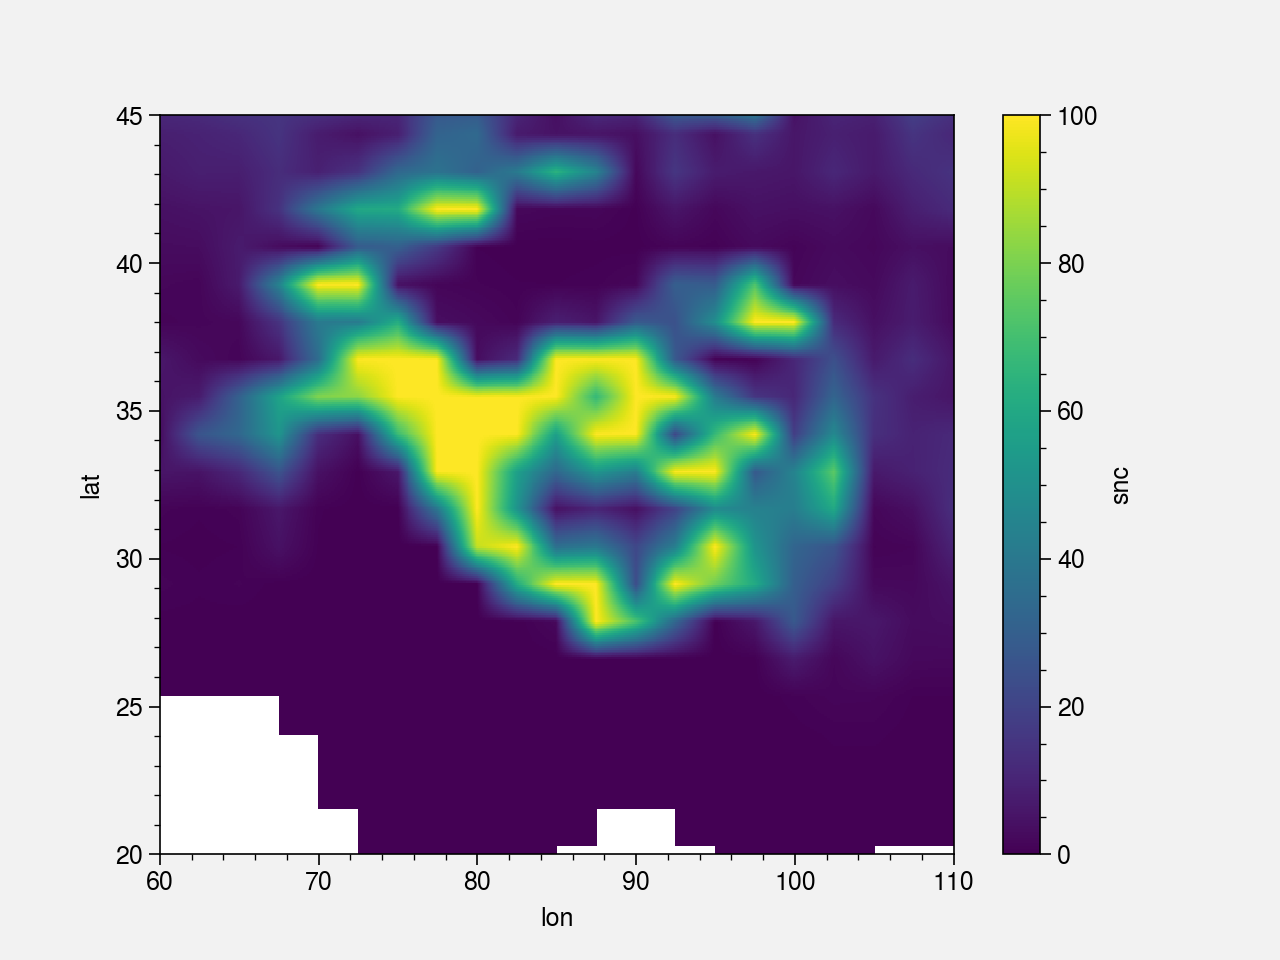

In [62]:
snc_historical_regrid.plot()

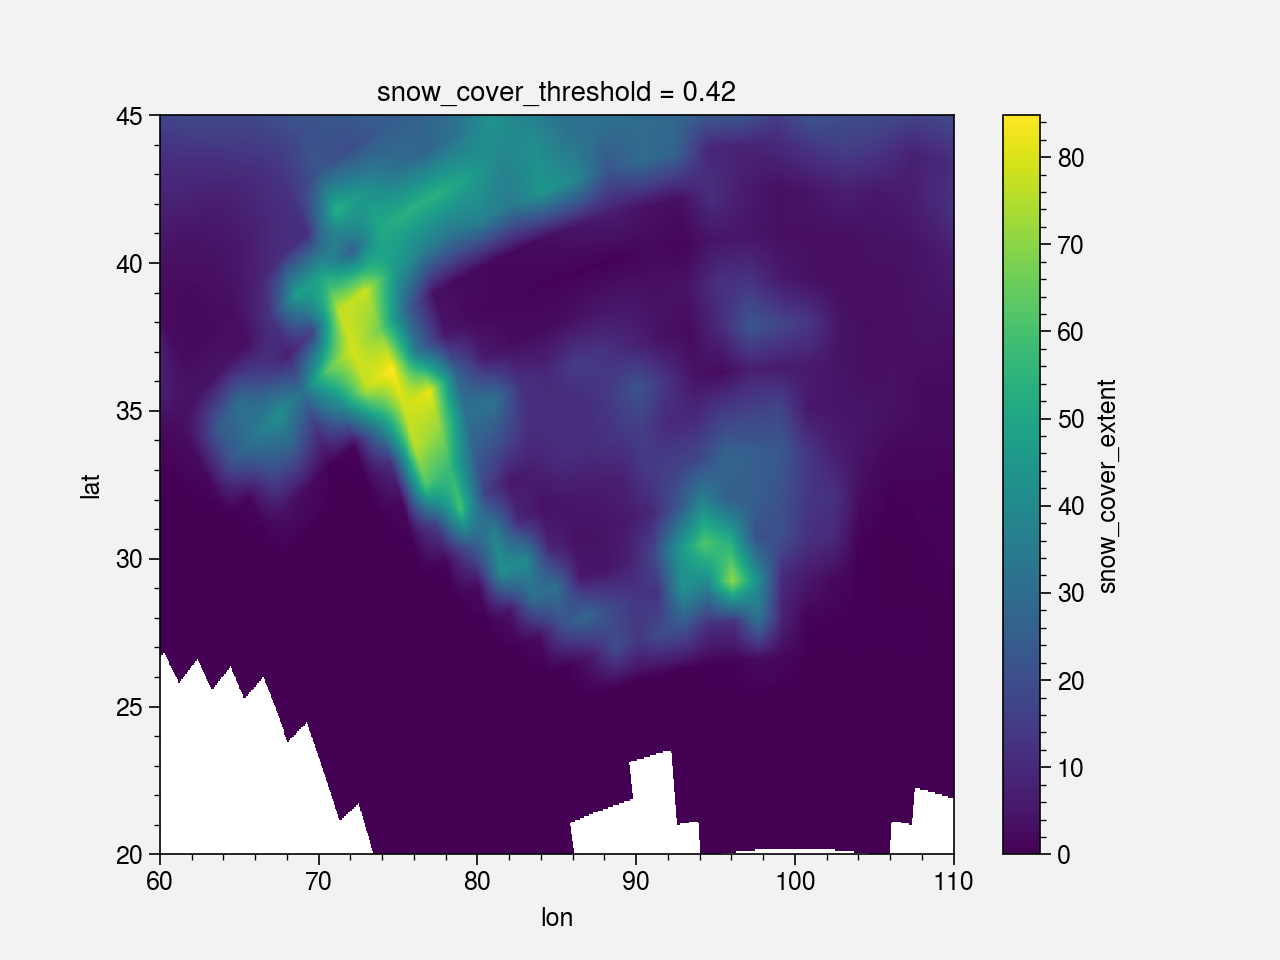

In [65]:
snc_rutger_regrid.mean('time').plot()

In [66]:
bias = snc_historical - snc_rutger_regrid.mean('time')

In [67]:
bias

<xarray.DataArray (time: 432, lat: 0, lon: 0)>
dask.array<sub, shape=(432, 0, 0), dtype=float64, chunksize=(432, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * lat                   (lat) float64 
  * lon                   (lon) float64 
  * time                  (time) datetime64[ns] 1979-01-16T12:00:00 ... 2014-...
    snow_cover_threshold  float32 0.42

In [78]:
bias.sel(lat=slice(26,30), lon=slice(85,88))

<xarray.DataArray (lat: 64, lon: 48)>
dask.array<getitem, shape=(64, 48), dtype=float64, chunksize=(64, 48), chunktype=numpy.ndarray>
Coordinates:
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float32 85.03125 85.09375 ... 87.90625 87.96875
  * lat                   (lat) float32 26.03125 26.09375 ... 29.90625 29.96875

In [27]:
T

array([[150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 195, 185, 160, 150, 140],
       [150, 200, 210, 220, 225, 220, 19

In [28]:
X

array([[ 0.        ,  1.        ,  1.5       ,  1.        ,  0.        ,
         2.        ,  4.        ,  5.        ,  4.        ,  2.        ,
         1.        ],
       [ 0.        ,  0.94581724,  1.41872586,  0.94581724,  0.        ,
         1.89163448,  3.78326897,  4.72908621,  3.78326897,  1.89163448,
         0.94581724],
       [ 0.        ,  0.78914051,  1.18371076,  0.78914051,  0.        ,
         1.57828102,  3.15656204,  3.94570255,  3.15656204,  1.57828102,
         0.78914051],
       [ 0.        ,  0.54694816,  0.82042224,  0.54694816,  0.        ,
         1.09389632,  2.18779263,  2.73474079,  2.18779263,  1.09389632,
         0.54694816],
       [ 0.        ,  0.24548549,  0.36822823,  0.24548549,  0.        ,
         0.49097097,  0.98194195,  1.22742744,  0.98194195,  0.49097097,
         0.24548549],
       [-0.        , -0.08257935, -0.12386902, -0.08257935, -0.        ,
        -0.16515869, -0.33031738, -0.41289673, -0.33031738, -0.16515869,
        -0.082

In [24]:
Y.size

220

In [30]:
cm.jet(topo_GMTED_zoom.values/float(topo_GMTED_zoom.values.max()))

array([[[0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        ...,
        [0.        , 0.        , 0.51782531, 1.        ],
        [0.        , 0.        , 0.51782531, 1.        ],
        [0.        , 0.        , 0.51782531, 1.        ]],

       [[0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        ...,
        [0.        , 0.        , 0.51782531, 1.        ],
        [0.        , 0.        , 0.51782531, 1.        ],
        [0.        , 0.        , 0.51782531, 1.        ]],

       [[0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        [0.        , 0.        , 0.53565062, 1.        ],
        ...,
        [0.        , 0.        , 0.51782531, 1.        ],
        [0.        , 0.      

In [33]:
topo_GMTED_zoom.lon.values.size

48

In [36]:
topo_GMTED_zoom.lat.values.size

64

In [39]:
topo_GMTED_zoom.values.shape

(64, 48)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


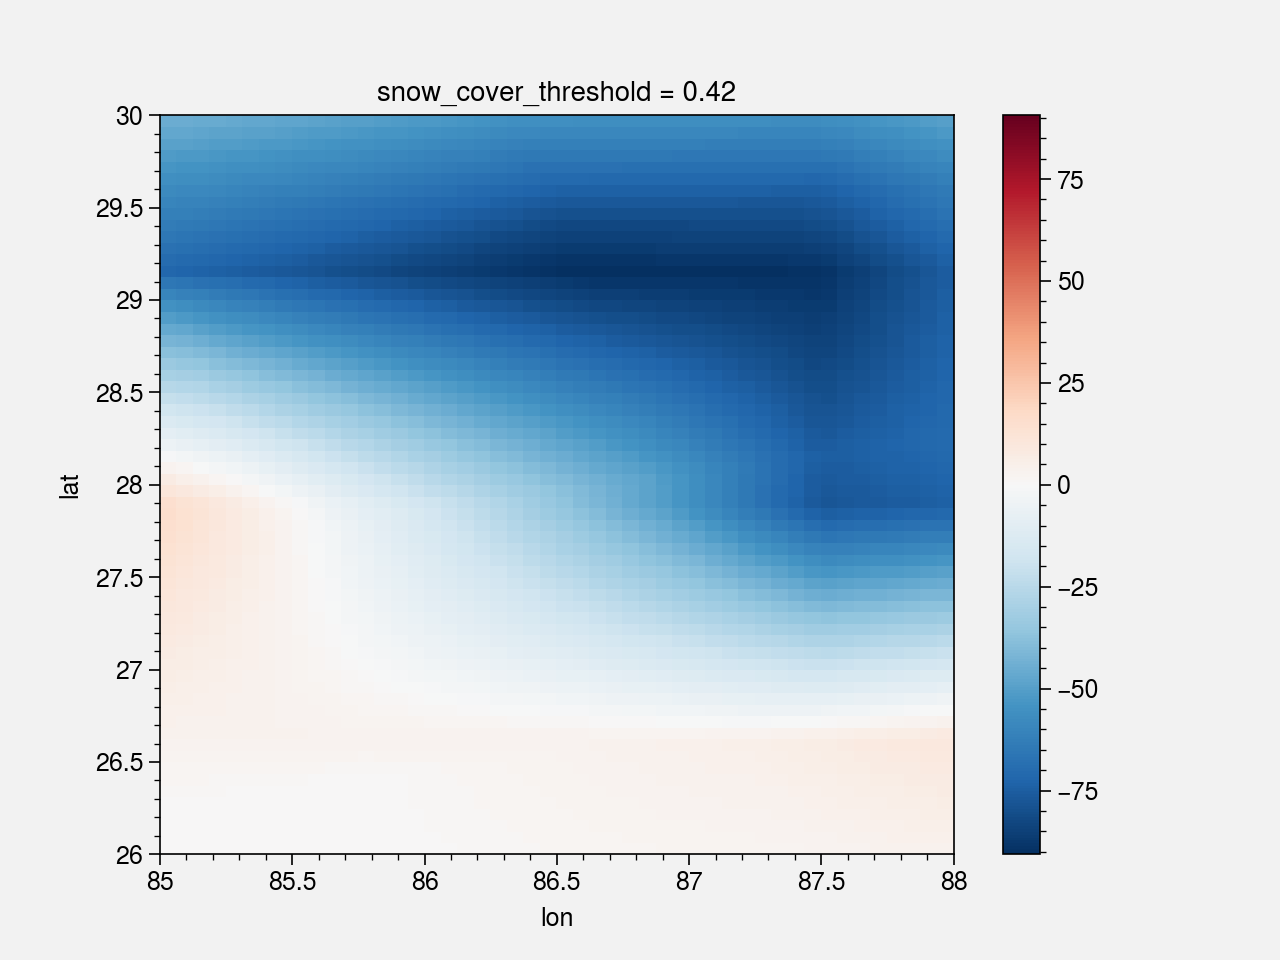

In [80]:
bias.sel(lat=slice(26,30), lon=slice(85,88)).plot()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


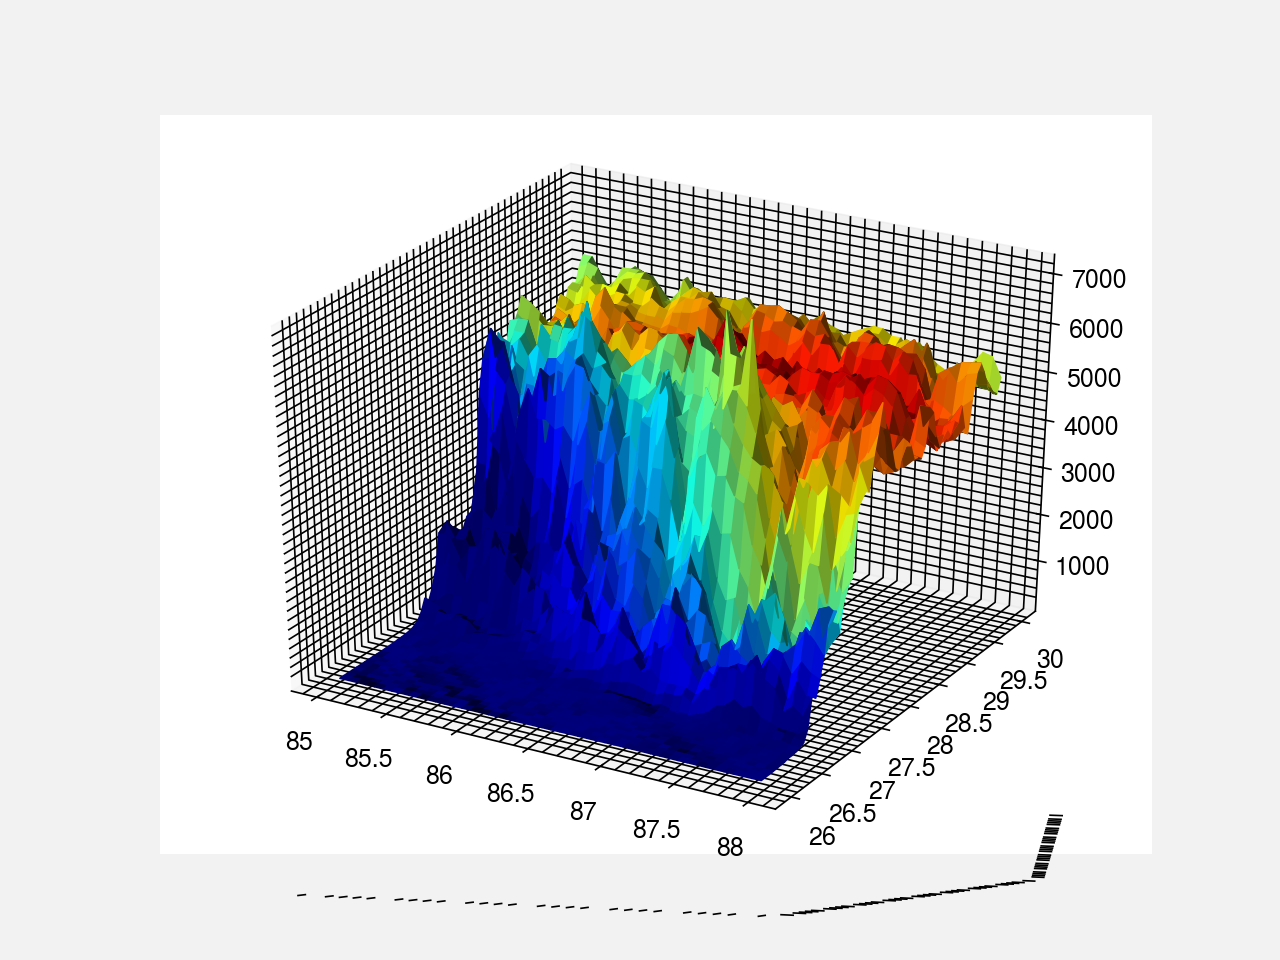

In [82]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(topo_GMTED_zoom.lon.values, topo_GMTED_zoom.lat.values)

# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.jet(T/float(T.max())))
ax.plot_surface(X, Y, topo_GMTED_zoom.values, rstride=1, cstride=1, 
                facecolors=cm.jet(bias.sel(lat=slice(26,30), lon=slice(85,88))/float(bias.sel(lat=slice(26,30), lon=slice(85,88)).min()))
               )
plt.show()